# Final Project - Game of Thrones

### Austin Chan, Deepak Mongia, Justin Herman, Chester Poon

## Introduction

Game of Thrones has been one of the most popular television shows in the past decade. For many people, GoT is the only reason they have a HBO subscription. While most people are familiar with Game of Thrones as a TV show, GoT actually comes from a series of books written by George R.R. Martin starting in 1996 with "A Song of Ice and Fire". Compared to the TV show, the books have a wider breadth of detail and character development that occurs over the course of the plot, which lends itself to text analysis.

For this project we are going to use NLP and network grpahs to analyze the relationships between the characters Game Of Thrones books. Using name entity recognition and sentiment analysis, we can determine the strength and nature of the relationships between characters and use that data to construct a network mapping the relationships of all characters for each book. All book files have been uploaded to github here: https://github.com/justinherman42/Data620/tree/master/GOT_Final_project/textfiles
 
The original text files were edited by hand to remove author's notes, the foreword, and the appendices because they are not relevant to the plot of the books and can clutter our analysis.

## Processing the Text

Before conducting the analysis, the text must be cleaned, tokenized, and stored. This removes a lot of the noise and common errors that can occur in text data like the overuse of stopwords, non-tokenized words with the same root being counted differently, and punctuation cluttering sentences. The section below describes how we processed the text.

### Loading the necessary packages

The code below loads the packages necessary for our analysis. `Pandas` is used for its dataframe functionality so that different types of data can be stored in the same object in a tabular format. `NLTK` contains many useful text processing and text analysis functions that will be used to handle text data. `Pathlib` is a library that is geared towards managing file directories and streamlining file loading. The `re` and `string` packages are used for regular expressions and string processing functions respectively. Both packages are very useful for removing junk text that can clutter the data. `Requests` is used to fetch data from the web. In our case, the data has been uploaded to github and we will be fetching it directly from there. The `sent_tokenize` function is used to tokenize our sentences. `Spacy` is the name entity recognition algorithm we are going to use to identify the characters in the text. `CountVectorizer` is a function in the `sklearn` package that converts a collection of text documents into a matrix of token counts. `Seaborn` is a graphing package that helps display data similar to matplotlib and ggplot. `Pyplot` will be used to display the seaborn plots in the ipython notebook. `set_style("darkgrid")` is just changing the settings in seaborn to a different theme for the plots.

In [12]:
import pandas as pd 
import nltk
from pathlib import Path
import re
import string
import requests
from nltk import sent_tokenize
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

### Creating a text cleaning function

The function below does a few things beyond cleaning text. The function takes in the name of the text to be fetched from github as its input and returns the cleaned text as output. In our case, this would be the names of the books as written in the github repository. The first line of the function creates the url by concatenating the base github url with the text file name. The second line fetches the web page stated in the url and the third line extracts just the raw text from the web page. Afterwards, the carriage return character, newline character, and backslash are all replaced with spaces. The text is then stored into a variable called `novel` and the ellipses are replaced with semicolons. The last line returns the clean text.

In [13]:
def clean_text(text_file):    
    '''
    Reads in text file from GITHUB gets rid of newline and special characters
    '''
    
    url = 'https://raw.githubusercontent.com/justinherman42/Data620/master/GOT_Final_project/textfiles/'+text_file
    page = requests.get(url)
    text=page.text
    data = text.replace('\r', ' ').replace('\n', ' ').replace("\'", "'")   
    novel=''
    novel += ' ' + data
    novel = novel.replace('. . .',';')
    return novel



### Storing the text in a dictionary

After the text has been cleaned, the text needs to be stored in a dictionary so that it can be used for name entity recognition. The code below mostly just runs the function created in the previous chunks with a few extra things. The first line specifies the file names of the books in the directory and puts them into a list. The second line initializes an empty dictionary to store the untokenized books. The third and fourth line are a for loop that runs the `clean_text` function on each book and stores it into the untokenized books dictionary. The next chunk initializes another empty dictionary that will store a tokenized version of the previous dictionary. There is another for loop that does the same thing as the previous for loop, except it tokenizes the text.

Now that the text has been loaded, processed, and stored, it is ready for name entity recognition.

In [14]:

## build out names for text file URL's
git_text_file_names=['got1.txt','got2.txt','got3.txt','got4.txt','got5.txt']

## Built out dictionary with untokenized data to use with the count vectorizer
## All I really saw in terms of issues was ... being frequently used which I substituted with ;

book_series_untokenized={}
for i,x in enumerate(git_text_file_names):
    book_series_untokenized["book{}".format(i+1)]=clean_text(x)

## built out dictionary with tokenized data
book_series={}
for i,x in enumerate(git_text_file_names):
    orig_text=clean_text(x)
    sentence_list = sent_tokenize(orig_text)
    book_series["book{}".format(i+1)]= sentence_list



In [15]:
type(book_series["book1"])

list

## Name Entity Recognition

Name entity recognition is a form of text processing that classifies named entities inside text corpora. In other words, it is possible for python to identify characters in sentences and relate them to other characters in the same sentence using part of speech tagging and grammar modeling techniques. We decided to use the SpaCY library for name recognition because it is a very robust package that has been trained on the OntoNotes corpora. This corpora is significant because it contains almost 3 million English words across many different genres of writing including newswire, broadcast news, broadcast conversation, telephone conversation, and web data. A link to the corpora can be found here: https://catalog.ldc.upenn.edu/LDC2013T19

While the SpaCY name entity recognition algorithm is powerful, it is not specifically suited for analyzing Game of Thrones books due to how certain words carry different meanings in the books compared to how they are used in spoken English. Therefore, we must specify a unique set of stopwords to handle these inconsistencies.

In [16]:
#Instantiate NLP for English
nlp = spacy.load('en')

### Creating Name Entity Recognition function

While the name entity recognition function can be used on the entire corpus all at once, it is typically prone to crashing due to the large amount of text that needs to be processed. Therefore, we made a version of the name entity recognition function that processes the text one sentence at a time to make the computation less intense (albeit, slower) than the original function.

The function below takes in a sentence string as input and retrieves the name entities from that sentence. The first line in this function is the `nlp` function from the SpaCY package. This function is an all-in-one text processing function that tokenizes, tags parts of speech, performs dependency parsing, lemmatizes, detects sentence boundaries, recognizes named entities, compares the similarity between words, classifies text, and a plethora of other functions. However, for our analysis, we are mainly interested in the named entity recognition functionality of this function.

The second line of code is a list comprehension that fetches every word labeled as a person. The next two lines lowercase the names and remove the possessive conjunction (Jon's to Jon). The next line removes names that are less than three characters long because the classifier incorrectly flags many short words as named entities.

In [17]:

def name_entity_recognition(sentence):
    '''
    A function to retrieve name entities in a sentence.
    :param sentence: the sentence to retrieve names from.
    :return: a name entity list of the sentence.
    '''

    doc = nlp(sentence)
    # retrieve person and organization's name from the sentence
    name_entity = [x for x in doc.ents if x.label_ in ['PERSON']]
    # convert all names to lowercase and remove 's and ’s in names
    name_entity = [str(x).lower().replace("'s","") for x in name_entity]
    name_entity = [x.replace("’s","") for x in name_entity]
    # remove name words that are less than 3 letters to raise recognition accuracy
    name_entity = [x for x in name_entity if len(x) >= 3]

    return name_entity



This function is a flattening function that transforms a multidimensional list into a single dimension. This function will be used to help return a unique list of names from a sentence.

The function is fairly straightforward. The first line initializes an empty list. The next few lines are a nested for loop that takes each item in a sublist and appends it to the flat list to create one long list.

In [18]:
def flatten(l):
    """A function that flattens a complex list"""
    flat_list = []
    for i in l:
        for j in i:
            flat_list.append(j)
    return flat_list

### Creating a name listing function

The function below creates a unique list of names from a sentence tokenized book taking the book as input. The first line initializes an empty list to store the names. The second through fourth lines are a for loop that iterates through each sentence in the book and inserts new names into the `names` list. There is an if statement that checks whether the named entities are not an empty list and appends the names to the `names` list before iterating to the next sentence. The last line invokes the `flatten` function from earlier to flatten the multidimensional list that the for loop created.

In [19]:
def nlist(book):
    """Returns a unique list of names from a sentence tokenized book"""
    names = []
    for i in book:
        if name_entity_recognition(i) != []:
            names.append(name_entity_recognition(i))
    names = list(set(flatten(names)))
    return names

The code below runs the `nlist` function on each book.

In [20]:
names_book1 = nlist(book_series["book1"])
names_book2 = nlist(book_series["book2"])
names_book3 = nlist(book_series["book3"])
names_book4 = nlist(book_series["book4"])
names_book5 = nlist(book_series["book5"])

There are a few more housekeeping things we need to do before jumping into the analysis. For some reason, SpaCY NER is not able to detect the name "tyrion" in a few of the books. Given that Tyrion is one of the main characters in the series, we manually added him to the name list for books 1, 2, and 4.

In [21]:
all_names_list = [names_book1,names_book2,names_book3,names_book4,names_book5]

# As shown below, for some unknown reason SpaCy NER was unable to detect Tyrion as a name entity
# in a few of the books
for i in all_names_list:
    print('tyrion' in i)

# We will manually enter Tyrion in for books 1, 2, and 4
names_book1.append('tyrion')
names_book2.append('tyrion')
names_book4.append('tyrion')

False
False
True
False
True


### Notes on Names in GOT

We created a list called `words` to remove words that the NER algorithm is mistakenly catching as name entities. Game of Thrones names are tricky because there are a few times where major characters in the books names can change and how they're referenced. We can keep the names separate to see how sentiment changes and even reveal how different the relationships can be when the characters are referenced under their alias.

- Arya
 - Some time in Book 4, Arya begins her training at the House of Black and White. She is called "Girl" from here moving forward.
- Jon Snow
 - When Jon Snow is called Jon in the book, it's in a positive light. When he's called "Snow", it's often in a negative one. It would be interesting to see the sentiment analysis confirm this.
- Dany
 - Also known as Daenarys.
- Ned Stark
 - Also known as Eddard.
- Pie
 - Hot Pie. 

The code below specifies a list of such words that were mistakenly identified as named entities.

In [22]:
""" We'll load certain words that SpaCy NER pulled as names that are not names to extricate them 
from the list. Game of Thrones names are tricky and it's helpful that some members of our group have 
read the books to be able to recognize some things as not names. For example, Pie is a character, but 
could easily be mistaken as the food.
"""
words = ['hand','father','maester','gods','winterfell','wine','uncle','sleep','broken',
        'wall','battle','watch','sweet','killed','north','child','kill','harrenhal','rock',
         'dothraki','dead','ser','blood','knew','sword','queen','wolf','words','horse','hands',
         'fingers','left','wildlings','daughter','word','fat','bastard','westeros','light',
         'yunkai','aye','meereen','knight','woman','gate',
         'lady', #removing lady. (***spoiler warning***) Although Lady is Sansa's wolf, Lady dies early and the NER algorithm
                 # continues to pick up lady due to it's use as in "Lady Stark", etc.
         'grace'] #removing grace since this person changes based on who sits on the iron throne
                


### Pulling the top 25 characters

Given that there are many, many characters that come and go throughout the series, it is unreasonable (and not particularly interesting) to analyze the relationships between every single character. For our analysis, we will focus on the top 25 characters in each book.

The function below fetches the frequency of each name in a given book. The first line counts the occurence of each name in the name list, not including english stop words. The next line of code converts the novel to lowercase and then normalizes the data using the `fit_transform` function. The next line of code converts the the normalized data to an array and then converts it into a dataframe. The next few lines transposes the data, then sorts it in descending order, and then filters the data frame to only the top 25 most frequent names. Afterwards, the names and frequencies are extracted and then returned.

In [23]:
def top_names(name_list, novel, top_num=25):
    '''
    Returns name freq of a book for each name
    '''

    vect = CountVectorizer(vocabulary=name_list, stop_words='english')
    name_frequency = vect.fit_transform([novel.lower()])
    name_frequency = pd.DataFrame(name_frequency.toarray(), columns=vect.get_feature_names())
    name_frequency = name_frequency.T
    name_frequency = name_frequency.sort_values(by=0, ascending=False)
    name_frequency = name_frequency[0:top_num]
    names = list(name_frequency.index)
    name_frequency = list(name_frequency[0])

    return name_frequency, names

### Removing more stopwords and storing the frequencies

The code below removes the special stopwords specified in the `words` list for each book and the `out_freq_df` function takes the output from the `top_names` function and transforms it into a dataframe for visualization. 

In [24]:
names1 = [x for x in names_book1 if x not in words]
names2 = [x for x in names_book2 if x not in words]
names3 = [x for x in names_book3 if x not in words]
names4 = [x for x in names_book4 if x not in words]
names5 = [x for x in names_book5 if x not in words]

def out_freq_df(name_freq):
    """Takes the items returned from top_names and returns a dataframe that will be fed into viz"""
    df = pd.DataFrame([name_freq[1],name_freq[0]]).transpose()
    df.columns = ['names','freq']
    return df

topnames1_df = out_freq_df(top_names(names1,book_series_untokenized['book1']))
topnames2_df = out_freq_df(top_names(names2,book_series_untokenized['book2']))
topnames3_df = out_freq_df(top_names(names3,book_series_untokenized['book3']))
topnames4_df = out_freq_df(top_names(names4,book_series_untokenized['book4']))
topnames5_df = out_freq_df(top_names(names5,book_series_untokenized['book5']))

This function is a plot function that simplifies the barplot from seaborn that takes the top names dataframes as input.

In [25]:
def name_freq_plot(df,title):
    """plot for name freq"""
    sns.barplot(data=df, 
                y=df.names, 
                x=df.freq,
                color='blue')
    plt.title(title)
    plt.show()

## Name Count Results

Shown below are the 25 most frequent names in each Game of Thrones book. As we can see, there are a few main characters that persist through all of the books with a rotating cast of supporting characters. Jon and Tyrion are almost always the most mentioned characters in all the books except for in the book "A Feast of Crows". As expected Arya's mentions drop significantly in the fourth book when she is referred to as "Girl" for the rest of the series.

C:\Users\super_000\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


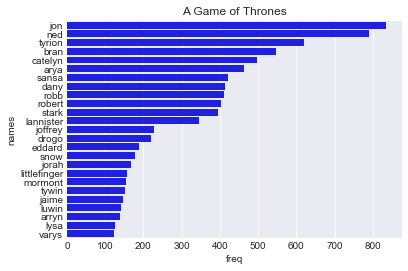

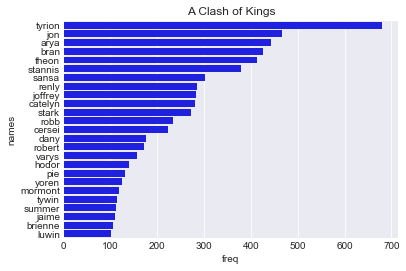

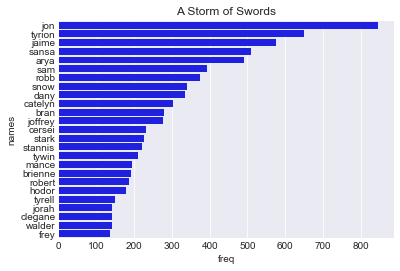

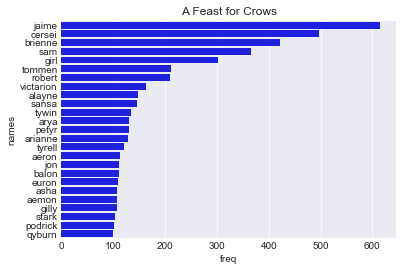

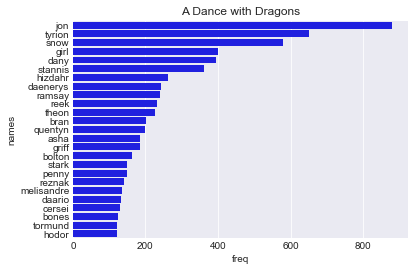

In [26]:
name_freq_plot(topnames1_df,'A Game of Thrones')
name_freq_plot(topnames2_df,'A Clash of Kings')
name_freq_plot(topnames3_df,'A Storm of Swords')
name_freq_plot(topnames4_df,'A Feast for Crows')
name_freq_plot(topnames5_df,'A Dance with Dragons')